# Bayesian Parameter Estimation of a Fluorescence-to-Protein Calibration Factor 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import scipy.stats
import theano.tensor as tt
import mscl_utils as mscl
import corner
mscl.set_plotting_style()
%matplotlib inline

## Counting By Measuring Fluctuations 

Imagine that we have a cell that has a fixed number of fluorescent proteins (meaning that the production rate is 0). As this cell divides, these proteins will be partitioned to one of the two daughter cells in a binomial  fastion.  By exmining the difference in fluorescence between the two daughters, we can determine just how "bright" a single molecule should be. 

We can begin by positing that the fluorescence is conserved (production and degradation rates are 0). Mathematically, we can say that 

$$
I_\text{tot} = I_1 + I_2 \tag{1}
$$

where $I_\text{tot}$ is the total fluorescence of the mother cell and $I_1$ and $I_2$ are the intensities of the two daugher cells. As we know this fluorescence comes from a mix of the background fluorescence and the fluorescence of the proteins themselves, we can write that the total intensitiy of the mother cell should be proportional to the total number of proteins $N_\text{tot}$,

$$
I_\text{tot} = \alpha N_\text{tot}, \tag{2}
$$

assuming (for now) that the background fluorescence and the error in our measurement is zero. Assuming that there is a single fluroescence calibration factor and that it has the same value from cell to cell, we can write Eq. 2 for the daughter cells as

$$
I_1 = \alpha N_1\,\, ; \,\, I_2 = \alpha N_2  \tag{3, 4}
$$

which follows the assumption that the protein copy number is conserved as well,

$$
N_\text{tot} = N_1 + N_2 \tag{5}.
$$

When a cell divides, the distribution of the proteins into the two daughter cells is binomial with a partitioning probability $p$,

$$
P(n \, \vert \, N_\text{tot}) = {N_\text{tot}! \over n! (N_\text{tot} - n)!} p^{n}(1 - p)^{N_\text{tot} - n}, \tag{6}
$$

Where we've generalized $N_1$ or $N_2$ as $n$. To examine how the proteins were partitioned amongst the daughter cells, we can look at how different the intensities are between them and relate it to the total intensity of the mother as 

$$
\langle(I_1 - I_2)^2\rangle = \langle (2I_1 - I_\text{tot})^2 \tag{7}
$$

which we can translate to protein copy numbers as 

$$
\langle(I_1 - I_2)^2\rangle = \langle\left(2\alpha N_1 - \alpha N_\text{tot}\right)^2\rangle. \tag{8}
$$

As we are discussing averages in this context, we can examine this more generally as

$$
\langle(I_1 - I_2)^2 \rangle = \alpha(2\langle n \rangle - N_\text{tot})^2 \tag{9}
$$

To finish our calculation, we will have to know the mean and variance of the protein copy number upon division. 





While these two moments of the Binomial distribution are well know, it's useful to derive them explicitly. The mean can be calculated as

$$
\langle n \rangle = \sum\limits_{n = 0}^{N_\text{tot}}n{{N_\text{tot}}\choose{n}}p^{n}(1-p)^{N_\text{tot} - n}. \tag{10}
$$

This can be simplified by realizing that

$$
n {N_\text{tot}! \over n!(N_\text{tot} - n)!} = {N_\text{tot}! \over (n-1)!(N_\text{tot} - n)!} = {N_\text{tot}(N_\text{tot} - 1)! \over (n - 1)!(N_\text{tot} - n)!} \tag{11}
$$

We can now rewrite Eq. 10 as

$$
\langle n \rangle = N_\text{tot} p \sum\limits_{n= 1}^{N_\text{tot}}{{N_\text{tot} - 1}\choose{n - 1}}p^{n - 1}(1 - p)^{N_\text{tot} - n + 1} \tag{12}
$$

By defining $\nu = N_\text{tot} - 1$ and $k = n - 1$, we yield. 

$$
\langle n \rangle = N_\text{tot} p \overbrace{\sum\limits_{k= 0}^{\nu}{{\nu}\choose{k}}p^k(1 - p)^{\nu - k}}^\text{1} = N_\text{tot} p \tag{13}
$$

which is what we would naïvely expect. With this in hand, we can naïvely solve for the variance. We can solve for $\langle n^2 \rangle$ as we did above by realizing 

$$
\langle n^2 \rangle = N_\text{tot}p\sum\limits_{n=1}^{N_\text{tot}}n{{N_\text{tot} - 1}\choose{n -1}}p^{n-1}(1 - p)^{N_\text{tot} - n} = N_\text{tot}p\sum\limits_{k=0}^\nu(k + 1){{\nu}\choose{k}}p^k(1-p)^{\nu - k}  \tag{14},
$$

where we pull the same trick of reparameterizing Eq. 13 for $\nu = N_\text{tot} - 1$ and $k = n - 1$. Simplifying Eq. 14 generates 

$$
\langle n^2 \rangle = (N_\text{tot}p)^2 + N_\text{tot}p(1 - p) \tag{15}
$$

allowing us to express the variance $\sigma^2$ as 

$$
\sigma^2 = \langle n^2 \rangle - \langle n \rangle^2 = N_\text{tot}p(1 - p). \tag{16}
$$



We can make our calculation a bit less verbose aby assuming that partitioning of the proteins is always fair such that $p = 0.5$. This means our mean and variance can be more simply written as 

$$
\langle n \rangle = {N_\text{tot} \over 2}\, ; \, \langle n^2 \rangle= {N_\text{tot}+ N_\text{tot}^2 \over 4}. \tag{17, 18}
$$

We can now return to Eq. 9 and include the mean copy number,

$$
\begin{align}
\langle (I_1 - I_2)^2 \rangle &= 4\alpha^2(\langle n^2 \rangle - \langle n \rangle N_\text{tot}) + (\alpha N_\text{tot})^2\\
& = 4\alpha^2\left({N_\text{tot} + N_\text{tot}^2 \over 4} - {2N_\text{tot}^2 \over 4}\right) + \alpha^2N_\text{tot}^2 \tag{19}.
\end{align}
$$

Some simplification brings us to our result, 

$$
\langle (I_1 - I_2)^2 \rangle = \alpha^2 N_\text{tot} = \alpha I_\text{tot}. \tag{20}
$$
 
This result tells us that the squared difference in the intensity between any two daughter cells should be linearly related to the intensity of the mother cell with a slope of the calibration factor $\alpha$. While this is a very beautiful result, our measurement is a bit more difficult.

## Incorporating Measurement Error

While we were rewarded for our mathematical efforts with Eq. 20, the practical use of this theoretical prediction is a bit more complicated. Primarily, we must be able to incoporate our error in the measurement of the single cell intensities. This means that our Eq. 20 becomes. 

$$
I_\text{tot} = \alpha_0 + \alpha N_\text{tot} + \epsilon \tag{21}
$$

where $\alpha_0$ is the background fluorescence of our sample and $\epsilon$ is our measurement error. In [Rosenfeld et al. 2005]() and [Brewster et al. 2014](), the calibration factor was determined by binning the observed data and then fitting the prediction to the mean, assuming the measurement error was 0. While this is an acceptable approach, choosing the appropriate bin width is difficult and can bias the results. A more robust approach would be to write a heirarchical model which models each cell division event individually and estimate a hyperparameter for the calibration factor. 



### Taking a Bayesian approach

We are interested in estimating two calibration parameters - $\alpha_0$ and $\alpha$ - and (as a consequence), the most likely protein copy numbers $N_1$ and $N_\text{tot}$. As is usually the case, we can begin by writing down Bayes' theorem for the problem, 

$$
P(\alpha_0, \alpha, \sigma, N_1, N_\text{tot}\,\vert\, I_1, I_2) = {P(I_1, I_2\, \vert \, \alpha_0, \alpha, \sigma, N_1, N_\text{tot})P(\alpha_0, \alpha, \sigma, N_1, N_\text{tot}) \over P(I_1, I_2) }. \tag{22}
$$

in which we've introduced the measurement error as $\sigma$ as it's related to the normal distribution of the measurements. Our likelihood can be broken up into three parts $--$ one for $I_1$, for $I_2$, and one for $[N_1, N_\text{tot}]$. As we've discussed already, the partitioning of the proteins into the daughter cells is binomial, allowing us to write

$$
P(N_1\, \vert\, N_\text{tot}, p) = {{N_\text{tot}}\choose{N_1}}p^{N_1}(1 - p)^{N_\text{tot} - N_1}. \tag{23}
$$

By assuming that partitioning is *always* fair (which may be a big assumption), we can simplify Eq. 23 to be

$$
P(N_1\, \vert \, N_\text{tot}, p) = {{N_\text{tot}}\choose{N_1}}2^{-N_\text{tot}}. \tag{24}
$$

It is likely that the measured intensity of a given cell is normally distributed. We can then say that for $I_1$, the  likelihood is gaussian with a variance $\sigma$,

$$
P(I_1 \,\vert\, \alpha_0, \alpha, N_1) = {1 \over \sqrt{2\pi \sigma^2}}\exp\left[{-(I_1 - (\alpha_0 + \alpha N_1)^2 \over 2\sigma^2}\right]. \tag{25}
$$

Similarly, we can write the likelihood for $I_2$ as 

$$
P(I_2 \,\vert\, \alpha_0, \alpha, N_1, N_\text{tot}) = {1 \over \sqrt{2 \pi \sigma^2}}\exp\left[{-(I_2 - (\alpha_0 + \alpha (N_\text{tot} - N_1))^2 \over 2 \sigma^2}\right] \tag{26}
$$

where we've again used the fact that protein copy number is conserved $N_\text{tot} = N_1 + N_2$. 

The priors can be a little more tricky to figure out. To begin simply, we can assume a uniform uninformative prior for the protein copy numbers $N_1$ and $N_\text{tot}$ using our knowledge that they must be discrete,

$$
P(N_1, N_\text{tot}) = \begin{cases} {1 \over n_\text{max} - n_\text{min}} && n \in \mathbb{Z}\, ;\, n_\text{min} \leq n \leq n_\text{max} \,;\, N_1 \leq N_\text{tot}\\
0 && \text{otherwise}
\end{cases}. \tag{27}
$$

Similarly, we can choose uniform priors for our two calibration parameters $\alpha_0$ and $\alpha$ as 

$$
P(\alpha_0, \alpha) = \begin{cases} {1 \over \alpha_\text{max} - \alpha_\text{min}} && \alpha_\text{min} \leq \alpha \leq \alpha_\text{max}\\
0 && \text{otherwise} 
\end{cases}. \tag{28}
$$

As is typically the case, we can assign an improper (i.e. unnormalized) Jeffrey's prior for $\sigma$,

$$
P(\sigma) = {1 \over \sigma}. \tag{29}
$$

With likelihoods and priors, we are ready to write down the complete posterior. For ease, we can ignore the evidence $P(I_1, I_2)$. As we are looking over $k$ cell divisions, we have a set of $[N_1, N_\text{tot}]$ and $[I_1, I_2]$,  

$$
P(\alpha_0, \alpha, \sigma, [N_1, N_\text{tot}]\,\vert\,I_1, I_2) \propto P(\alpha, \alpha_0, [N_1, N_\text{tot}]){1 \over \sigma}\prod\limits_{i}^{k}{{N_{\text{tot},i}}\choose{N_{1,i}}}2^{-N_{\text{tot},i}}\times
\left({1 \over 2\pi \sigma^2}\right)^k\exp\left[{1 \over 2\sigma^2}\sum\limits_{i}^{k}\left((I_{1,i} - (\alpha_0 + \alpha N_{1,i}))^2 + (I_{2, i} - (\alpha_0 + \alpha(N_{\text{tot},i} - N_{1,i})))^2\right)\right], \tag{30}
$$

in which the priors for $\alpha_0, \alpha,$ and $[N_1, N_\text{tot}]$ were left out for notational clarity. 

While we could continue on to sample this distribution using MCMC, we have to be very careful of the priors. For example, with a $2k + 3$ parameter sampling, any degeree of information included in our prior will be greatly amplified and can steer the sampling off into other low-probabability local minima. We can reduce this issue by marginalizing Eq. 30 over $\sigma$,

$$
P(\alpha_0, \alpha, [N_1, N_\text{tot}] \, \vert\, [I_1, I_2]) = \int\limits_0^\infty d\sigma P(\alpha_0, \alpha, \sigma, [N_1, N_\text{tot}]\,\vert\,[I_1, I_2]). \tag{31}
$$

While this is a gnarly integral, the result is well studied and is the Student-t distribution, 

$$
\begin{align}
P(\alpha_0, \alpha, [N_1, N_\text{tot}] \, \vert \, [I_1, I_2]) \propto &\prod\limits_i^k {{N_{\text{tot},i}}\choose{N_{1,i}}}2^{-N_{\text{tot},i}}\times\\
&\left(\sum\limits_i^k \left((I_{1,i} - \alpha_0 - \alpha N_{1,i}))^2 + (I_{2,i} - \alpha_0 - \alpha(N_{\text{tot},i} - N_{1,i}))^2\right)\right)^{-k / 2}. \tag{32}
\end{align}
$$

Rather than jumping immediately into analyzing *real* data, we can test it on something we know.

### Analyzing simulated data

To ensure that this type of inference is appropriate, we will generate a fake data set in which the calibration factor and the background fluorescence is known *a priori*. We can choose values that are physically realistic, as is done in the code cell below.

In [24]:
# Set the parameters to generate the data set.
n_cells = 200
max_proteins = 800 
# sigma = 20 
# alpha_seed = np.random.normal(200, sigma)
alpha_seed = 50
# alpha_0 = 0

# Set the parent protein copy numbers and partition into children.
n_tot = (np.random.rand(n_cells) * max_proteins).astype(int) 
n_1 = np.random.binomial(n_tot, p=0.5)
n_2 = n_tot - n_1

# Compute the intensities.
I_1 = alpha_seed * n_1
I_2 = alpha_seed * n_2
I_tot = alpha_seed * n_tot

# Make it a DataFrame and compute the quantity of interest.
df = pd.DataFrame(np.array([n_tot, n_1, n_2, I_1, I_2, I_tot]).T, columns=['n_tot', 'n_1', 'n_2',
                                                         'I_1', 'I_2', 'I_tot'])
df.loc[:, 'sq_diff'] = (df['I_1'] - df['I_2'])**2

# Generate the prediction from the theory.
I_tot_range = np.logspace(2, 5, 300)
prediction = alpha_seed * I_tot_range

To prove that this synthetic data is in line with our derivation above, we can plot the raw points along with Eq. 20. 

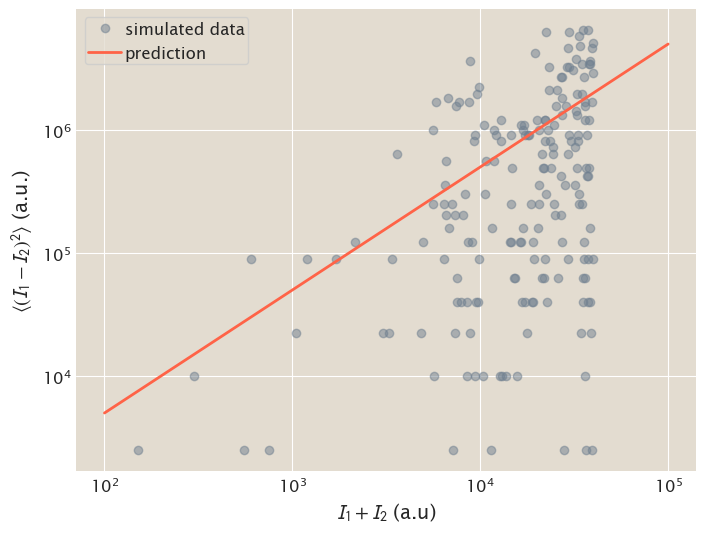

In [25]:
# Instantiate the figure and add axis labels. 
fig, ax = plt.subplots(1,1)
_ = ax.set_xlabel('$I_1 + I_2$ (a.u)')
_ = ax.set_ylabel(r'$\langle (I_1 - I_2)^2 \rangle$ (a.u.)')

# Set the scaling.
ax.set_yscale('log')
ax.set_xscale('log')

# Plot the data and the theoretical prediction.
_ = ax.plot(df['I_tot'], df['sq_diff'], 'o', color='slategray', alpha=0.5,
           label='simulated data')
_ = ax.plot(I_tot_range, prediction, '-', color='tomato', label='prediction') 

# Add a legend.
_ = ax.legend(loc='upper left')

As expected, our theoretical result matches the simulated data. To sample Eq. 32, we will use the package [PyMC3]() which has a wide variety of samplers and simple tools for constructing complicated models.

In [26]:
# Define the model.
with pm.Model() as model:
    
    # Define the priors. 
    alpha = pm.Uniform('alpha', lower=10, upper=100)
    
    # Take the Normal approximation of binomial.
    n_tot = pm.Uniform('N_tot', lower=0, upper=1000, shape=n_cells)
    p = 0.5
    mu_bino = n_tot * p
    sigma_bino = n_tot * p**2 
    n1 = pm.Normal('n1', mu=mu_bino, sd=sigma_bino, shape=n_cells)
     
    # Compute the means and covariance matrix for the Student-t for the Intensity likelihood.
    mu_1 = alpha * n_1
    mu_2 = alpha * (n_tot - n_1)
    
    # Define the observables.
    obs = df.loc[:, ['I_1', 'I_2']].values
   
    # Build the custom likelihood in the correct manner.
    class BivariateStudentT(pm.Continuous):
        """
        A Bivariate Student-t distribution ignoring normalization parameters of 
        the form
        
        g(µ1, µ2, k | θ1, θ2) = (Σ((θ1 - μ1)^2 + (θ2 - μ2)^2))^(-k/2)
        
        
        Parameters
        ----------
        mu1, mu2 : PyMC3 RV objects
            The two means of the components of the distribution.
        k : int 
            Length of set. 
        """
        
        def __init__(self, mu1=None, mu2=None, k=None, *args, **kwargs):  
            super(BivariateStudentT, self).__init__(*args, **kwargs)
            self.k = k = pm.theanof.floatX(tt.as_tensor_variable(k))
            self.mu1 = mu1 = pm.theanof.floatX(tt.as_tensor_variable(mu1))
            self.mu2 = mu2 = pm.theanof.floatX(tt.as_tensor_variable(mu2))
                
        def logp(self, values): 
            k = self.k
            mu1 = self.mu1
            mu2 = self.mu2
            return -k / 2 * tt.log(((values[:, 0] - mu1)**2 + (values[:, 1] - mu2)**2).sum())
       
    # Assign the likelihood function
    likelihood = BivariateStudentT('like', mu1=mu_1, mu2=mu_2, k=n_cells, observed=obs)

In [ ]:
with model:
    trace = pm.sample(draws=50000, tune=10000, njobs=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 71%|███████▏  | 42884/60000 [56:28<1:05:23,  4.36it/s]/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.419842887928, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 31228 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 82%|████████▏ | 48948/60000 [1:12:28<40:00,  4.60it/s]  

In [ ]:
trace_df = pm.trace_to_dataframe(trace)
sub_df = trace_df.loc[:, ['alpha', 'N_tot__1']]

In [ ]:
_ = corner.corner(sub_df)

In [17]:
alpha_seed

50